In [27]:

import pandas as pd
import numpy as np
import random
import time
import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


import csv
import os

import torch

from torch.utils.data import Dataset, DataLoader 

from torch.nn import Transformer

from train_utils import (cal_running_avg_loss, eta, progress_bar,
                         time_since, user_friendly_time)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
df = pd.read_csv('./tryshot_nan_20241030_1.csv')

In [4]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,90085,90086,90087,90088,90089,90090,90091,90092,90093,90094
registration_time,2019-01-02 16:45:06,2019-01-02 16:45:08,2019-01-02 16:45:58,2019-01-02 16:48:03,2019-01-02 16:50:08,2019-01-02 16:52:13,2019-01-02 16:55:18,2019-01-02 16:57:20,2019-01-02 16:59:28,2019-01-02 17:01:27,...,2019-03-31 23:41:19,2019-03-31 23:43:21,2019-03-31 23:45:23,2019-03-31 23:47:23,2019-03-31 23:49:26,2019-03-31 23:51:29,2019-03-31 23:53:28,2019-03-31 23:55:44,2019-03-31 23:57:46,2019-03-31 23:59:48
count,258,243,244,245,246,247,248,249,250,251,...,66,67,68,69,70,71,72,73,74,75
working,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
molten_temp,731.0,720.0,721.0,721.0,721.0,722.0,723.0,723.0,723.0,723.0,...,728.0,728.0,729.0,730.0,731.0,731.0,731.0,732.0,732.0,732.0
facility_operation_cycleTime,119,98,98,100,99,100,104,101,102,99,...,120,121,121,120,122,122,120,122,133,122
production_cycletime,120,125,122,125,123,125,129,182,122,124,...,121,122,122,121,122,122,121,135,122,123
low_section_speed,110.0,109.0,109.0,112.0,109.0,110.0,109.0,110.0,109.0,111.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
high_section_speed,112.0,109.0,109.0,109.0,110.0,110.0,111.0,108.0,111.0,108.0,...,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0
molten_volume,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,...,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0
cast_pressure,331.0,309.0,309.0,308.0,309.0,308.0,308.0,309.0,310.0,308.0,...,331.0,332.0,332.0,331.0,331.0,331.0,331.0,331.0,331.0,331.0


1. 온도, 압력 활용
- 가장 영향을 많이 주는 변수 (lower/uper/pressure/molten_temp/coolant_temp)

In [5]:
keep_columns = ['molten_temp', 'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3', 'lower_mold_temp1', 'lower_mold_temp2', 
                'lower_mold_temp3', 'sleeve_temperature', 'mold_code', 'passorfail']

In [7]:
df1 = df[keep_columns]

In [8]:
df1.iloc[:,:-1].values # x변수

array([[ 731.,  198.,  116., ..., 1449.,  550., 8722.],
       [ 720.,  250.,  113., ..., 1449.,  481., 8412.],
       [ 721.,  250.,  113., ..., 1449.,  481., 8412.],
       ...,
       [ 732.,   79.,  184., ..., 1449.,  272., 8917.],
       [ 732.,   82.,  185., ..., 1449.,  288., 8917.],
       [ 732.,   84.,  185., ..., 1449.,  289., 8917.]])

In [9]:
df1.iloc[:,-1:].values # target

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [10]:
class time_series_dataset(Dataset):
    def __init__(self, data, window_size=5):
        self.df = data
        self.window_size = window_size
        self.features = self.df.iloc[:, :-1].values # target을 제외한 나머지 feature

In [32]:
# 정규화 데이터셋을 위한 코드
scaler = MinMaxScaler()

features = df1.drop(columns=['passorfail']) 
scaled_features = scaler.fit_transform(features)
df_final_scale = pd.DataFrame(scaled_features, columns=features.columns)
df_final_scale['passorfail'] = df1['passorfail'].values

In [33]:
df_final_scale

,molten_temp,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,mold_code,passorfail
0,0.994558,0.125175,0.023951,1.0,0.613181,0.610766,0.017637,0.367792,0.613861,0.0
1,0.979592,0.161538,0.023239,1.0,0.538682,0.293996,0.017637,0.319269,0.000000,0.0
2,0.980952,0.161538,0.023239,1.0,0.538682,0.293996,0.017637,0.319269,0.000000,0.0
3,0.980952,0.174126,0.025373,1.0,0.547278,0.327122,0.017637,0.320675,0.000000,0.0
4,0.980952,0.179720,0.026796,1.0,0.561605,0.343685,0.017637,0.322785,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
90090,0.994558,0.044755,0.039839,1.0,0.604585,0.372671,0.017637,0.177215,1.000000,0.0
90091,0.994558,0.044755,0.040076,1.0,0.607450,0.372671,0.017637,0.177215,1.000000,0.0
90092,0.995918,0.041958,0.040076,1.0,0.587393,0.360248,0.017637,0.172293,1.000000,0.0
90093,0.995918,0.044056,0.040313,1.0,0.593123,0.368530,0.017637,0.183544,1.000000,0.0


In [43]:
# smote를 위한 코드
X = df_final_scale.drop(columns=['passorfail']) 
y = df_final_scale['passorfail'] 

smote = SMOTE(sampling_strategy={1: 40000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

smote_df = pd.DataFrame(X_resampled, columns=X.columns)
smote_df['passorfail'] = y_resampled

smote_df_0 = smote_df[smote_df['passorfail'] == 0].sample(n=40000, random_state=42)
smote_df_1 = smote_df[smote_df['passorfail'] == 1]

final_smote_df = pd.concat([smote_df_0, smote_df_1])

# 결과
print(final_smote_df['passorfail'].value_counts())

passorfail
0.0    40000
1.0    40000
Name: count, dtype: int64


In [44]:
# 커스텀데이터셋 형태 전부 동일
class time_series_dataset(Dataset):
    def __init__(self, data, window_size=5):
        self.df = data
        self.window_size = window_size
        # pandas -> numpy array 변환
        self.features = self.df.iloc[:, :-1].values # target을 제외한 나머지 feature
        self.target = torch.tensor(self.df.iloc[:, -1].values, dtype=torch.float32).view(-1,1) # target
        # self.target = self.df.iloc[:, -1:].values # 이것두 가능
        
    def __len__(self):
        return len(self.df) - self.window_size # window size만큼 마지막 데이터 삭제해줌. 시퀀스 구성 못 함
        # return self.target.shape[0] - self.window_size 가능
    
    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx : idx+self.window_size], dtype=torch.float32) # window size만큼 idx 가져오기
        # target = self.target[idx : idx+self.window_size] 다시점
        target = self.target[idx+self.window_size] # 단일 시점
        
        return features, target

In [39]:
# dataloader - label 1: 2000, label 0 : 89000
dataset1 = time_series_dataset(df1)
data_loader1 = DataLoader(dataset1, batch_size=256, shuffle=True)

In [34]:
# dataloader - 정규화 df
dataset1 = time_series_dataset(df_final_scale)
data_loader1 = DataLoader(dataset1, batch_size=256, shuffle=True)

In [45]:
# dataloader - smote df
dataset1 = time_series_dataset(final_smote_df)
data_loader1 = DataLoader(dataset1, batch_size=256, shuffle=True)

In [35]:
# LSTM_Transformer 모델 공통 사용
class LSTM_Transformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, window_size, output_dim, layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.window_size = window_size
        self.output_dim = output_dim
        self.layers = layers
        self.LSTM = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True) # batch, feature_num(input_dim), hidden_dim(output_dim) 형태 유지
        self.transformer = Transformer(d_model = 128, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim) # hidden_dim -> output dim(1)
        self.dropout = nn.Dropout(0.1)
        
    # transformer 디코더 마스크 함수 추가. 필요하면 사용 예정
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        # 셀프 초기화
        h0 = torch.zeros(self.layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layers, x.size(0), self.hidden_dim).to(device)
        
        lstm_output, (_, _) = self.LSTM(x, (h0, c0)) # 시퀀스 last time stap 정보. 여기서는 out만 사용
        output = self.transformer(lstm_output, lstm_output) # scr, tgt input으로 받음
        output = torch.mean(output, dim=1)
        output = self.dropout(output)
        output = self.fc(output) # 128 -> 1
        logit = torch.sigmoid(output)
        
        return output, logit

In [16]:
# original LSTM만 구현. 실제 학습엔 사용하지 않음
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers = layers
        
        # LSTM 레이어 정의
        self.LSTM = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  # hidden_dim -> output_dim (1)
        
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # LSTM 초기화
        h0 = torch.zeros(self.layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layers, x.size(0), self.hidden_dim).to(x.device)
        
        # LSTM 통과
        lstm_output, (_, _) = self.LSTM(x, (h0, c0))
        output = lstm_output[:, -1, :] 
        output = self.dropout(output) 
        output = self.fc(output) 
        logit = torch.sigmoid(output)   
        
        return output, logit

In [18]:
# GPU 사용
use_cuda = torch.cuda.is_available()
gpu_ids = [7]
device = torch.device('cuda:{}'.format(gpu_ids[0]))
print(device)

cuda:7


In [74]:
# 모델 선언. only LSTM
model_LSTM = LSTM(input_dim=10, hidden_dim=128, output_dim=1, layers=2).to(device)

In [20]:
# 모델 선언. 실제 학습에 사용
model = LSTM_Transformer(input_dim=9, hidden_dim=128, window_size=10, output_dim=1, layers=2).to(device)

In [21]:
BCEloss = torch.nn.BCELoss().to(device)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [40]:
# 불균형 데이터셋을 위한 가중치 적용한 커스터마이징 함수
def weighted_binary_cross_entropy(output, target, weights=None):

    epsilon = 1e-8
    output = torch.clamp(output, epsilon, 1 - epsilon)

    if weights is not None:
        assert len(weights) == 2, "weights 리스트는 두 개의 가중치를 포함해야 합니다."
        # 가중치 적용
        loss = weights[0] * (target * torch.log(output)) + \
               weights[1] * ((1 - target) * torch.log(1 - output))
    else:
        # 기본 BCE 손실 계산
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    # 평균 손실 값 return
    return torch.neg(torch.mean(loss))

weights = [3.0, 1.0] # 3:1로 1(불량)에 3 부여.

In [ ]:
# 학습 코드는 가장 성능이 좋은 smote data 기준으로 작성된 상태
def train(num_epochs):
    running_avg_loss = 0.0
    correct = 0.0
    total = 0.0
    total_len = 0
    
    # best_loss = 1e5
    batch_nb = len(data_loader1)
    step = 1
    model.zero_grad()
    for epoch in range(1, num_epochs+1):
        
        start = time.time()
        model.train()
        
        all_predicted = []
        all_targets = []    
        for batch_idx, batch in enumerate(data_loader1, start=1):       
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            output, logit = model(inputs)
            loss = BCEloss(logit, targets) # 학습에 따라 해당 함수 바꿔가면서 사용
            # loss = weighted_binary_cross_entropy(output, targets, weights=weights)
            # print('logit :',logit)
            # print('target :',targets)
            loss.backward()
            optimizer.step()
            # self.lr_scheduler.step()
            model.zero_grad()
            
            predicted = torch.round(logit.view(-1))
            # result = predicted.cpu().detach().numpy().argmax(axis=1)  # argmax로 0, 1 변환
            
            targets_flat = targets.view(-1)
            all_predicted.extend(predicted.cpu().detach().numpy()) 
            all_targets.extend(targets_flat.cpu().detach().numpy()) 
            
            correct += (predicted.view(-1) == targets_flat).sum().item()
            total_len += targets_flat.size(0)
    
        train_acc = (correct / total_len) * 100
        precision = precision_score(all_targets, all_predicted)
        recall = recall_score(all_targets, all_predicted)
        f1 = f1_score(all_targets, all_predicted)
        
        print(f'{epoch} 에폭, 정확도: {train_acc:.2f}, 정밀도: {precision:.2f}, 재현율: {recall:.2f}, F1-score: {f1:.2f}')
        
        # 마지막 에폭에서만 혼동 행렬 시각화
        if epoch == num_epochs:
            conf_matrix = confusion_matrix(all_targets, all_predicted)
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix for Epoch {epoch}')
            plt.show()

1 에폭, 정확도: 76.47, 정밀도: 0.78, 재현율: 0.73, F1-score: 0.76
2 에폭, 정확도: 83.73, 정밀도: 0.94, 재현율: 0.87, F1-score: 0.91
3 에폭, 정확도: 86.24, 정밀도: 0.94, 재현율: 0.88, F1-score: 0.91
4 에폭, 정확도: 87.57, 정밀도: 0.94, 재현율: 0.88, F1-score: 0.91
5 에폭, 정확도: 88.41, 정밀도: 0.95, 재현율: 0.89, F1-score: 0.91
6 에폭, 정확도: 88.99, 정밀도: 0.95, 재현율: 0.89, F1-score: 0.92
7 에폭, 정확도: 89.44, 정밀도: 0.95, 재현율: 0.89, F1-score: 0.92
8 에폭, 정확도: 89.81, 정밀도: 0.95, 재현율: 0.90, F1-score: 0.92
9 에폭, 정확도: 90.12, 정밀도: 0.95, 재현율: 0.90, F1-score: 0.92
10 에폭, 정확도: 90.38, 정밀도: 0.95, 재현율: 0.90, F1-score: 0.93


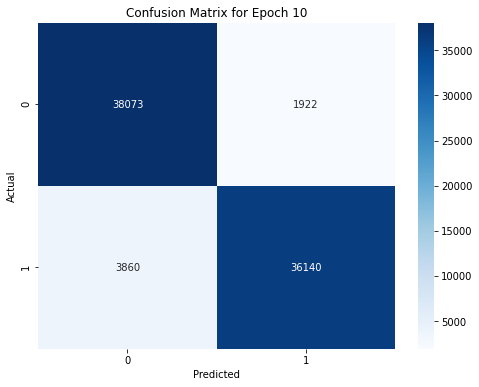

In [47]:
train(10)